In [165]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_11473/2008134232.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Data

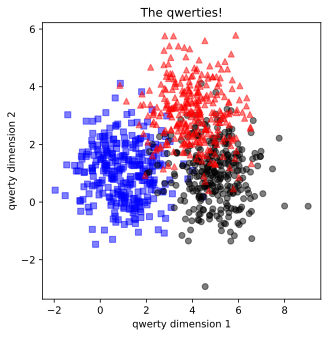

In [166]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [167]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Model

In [168]:
# Create a class for the neural network model and associated functions.

# Define a class for the neural network model.
def createTheQwertyNet(momentum, learning_rate=.01):
    # Define a custom class for the neural network model.
    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer: It has 2 input features and connects to 8 neurons.
            self.input = nn.Linear(2, 8)

            # Hidden layer: One hidden layer with 8 neurons.
            self.fc1 = nn.Linear(8, 8)

            # Output layer: Connects to 3 neurons for classification (3 classes).
            self.output = nn.Linear(8, 3)

        # Forward pass: Defines how data flows through the network.
        def forward(self, x):
            # Apply Rectified Linear Unit (ReLU) activation to the input layer.
            x = F.relu(self.input(x))
            
            # Apply ReLU activation to the hidden layer.
            x = F.relu(self.fc1(x))
            
            # Pass the result through the output layer.
            return self.output(x)

    # Create an instance of the neural network model.
    net = qwertyNet()

    # Define the loss function (Cross Entropy Loss) for classification tasks.
    lossfun = nn.CrossEntropyLoss()

    # Define the optimizer (Stochastic Gradient Descent) with specified learning rate and momentum.
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

    # Return the created neural network, loss function, and optimizer.
    return net, lossfun, optimizer


In [169]:
# Confirm that the optimizer has momentum

# Create an instance of the optimizer with specified momentum.
optim = createTheQwertyNet(0.9)[2]

# Output the optimizer instance.
optim


SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

# Training

In [170]:
# a function that trains the model


# number of epochs
numepochs = 50


def function2trainTheModel(momentum, learning_rate=.01):
  
  # create a new model
  net,lossfun,optimizer = createTheQwertyNet(momentum, learning_rate)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) ) 
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Now for the experiment!

In [162]:
# Test different momentum values during training

# Explanation:
# In this code snippet, we are conducting an experiment to evaluate the impact of different momentum values during the training of a neural network model.
# The `momenta` list contains various momentum values (0, 0.5, 0.9, 0.95, 0.999) that we want to test.
# momenta = [0, 0.5, 0.9, 0.95, 0.999]
# momenta = [0.999, 0.999, 0.999]
momenta = np.linspace(0.9, 0.99, 10)

# Initialize a results matrix to store training results.
results = np.zeros((numepochs, len(momenta), 3))

# Explanation:
# The `results` matrix is a multidimensional array with dimensions (numepochs, len(momenta), 3). It will be used to store training results, including losses, training accuracy, and test accuracy. Each dimension of the matrix corresponds to different aspects of the results.

# Test all momentum values on the same data with different model instances.
for idx, mom in enumerate(momenta):
    # Explanation:
    # Within this loop, we iterate through the `momenta` list, and for each momentum value (`mom`), we call a function (presumably `function2trainTheModel`) to train the neural network model with that specific momentum value.

    # Call a function to train the model with the specified momentum.
    trainAcc, testAcc, losses, net = function2trainTheModel(mom)
    
    # Explanation:
    # The training results, including training accuracy, test accuracy, and losses, are obtained from the training process using the specified momentum value. These results are then stored in the `results` matrix.

    # Store the training losses, training accuracy, and test accuracy in the results matrix.
    results[:, idx, 0] = losses  # Column 0 stores losses
    results[:, idx, 1] = trainAcc  # Column 1 stores training accuracy
    results[:, idx, 2] = testAcc  # Column 2 stores test accuracy

# Explanation:
# After the loop completes, the `results` matrix contains the training results for each tested momentum value. This experimentation helps us understand how different momentum values affect the training process of the neural network model.


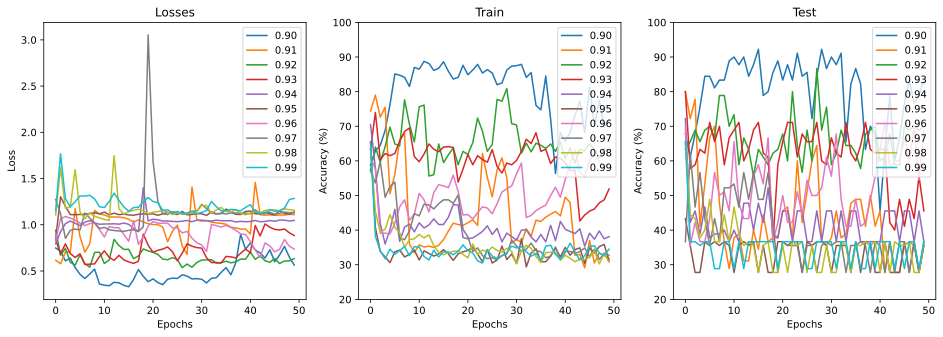

In [163]:
fig,ax = plt.subplots(1,3,figsize=(16,5))

for i in range(3):
  ax[i].plot(results[:,:,i])
  # ax[i].legend(momenta)
  ax[i].legend(
    labels=[f'{float(x):.2f}' for x in momenta])
  ax[i].set_xlabel('Epochs')
  if i==0:
    ax[i].set_ylabel('Loss')
  else:
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([20,100])

ax[0].set_title('Losses')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()

Training with momentum=0.900, learning_rate=0.000100
Training with momentum=0.900, learning_rate=0.000144
Training with momentum=0.900, learning_rate=0.000207
Training with momentum=0.900, learning_rate=0.000298
Training with momentum=0.900, learning_rate=0.000428
Training with momentum=0.900, learning_rate=0.000616
Training with momentum=0.900, learning_rate=0.000886
Training with momentum=0.900, learning_rate=0.001274
Training with momentum=0.900, learning_rate=0.001833
Training with momentum=0.900, learning_rate=0.002637
Training with momentum=0.900, learning_rate=0.003793
Training with momentum=0.900, learning_rate=0.005456
Training with momentum=0.900, learning_rate=0.007848
Training with momentum=0.900, learning_rate=0.011288
Training with momentum=0.900, learning_rate=0.016238
Training with momentum=0.900, learning_rate=0.023357
Training with momentum=0.900, learning_rate=0.033598
Training with momentum=0.900, learning_rate=0.048329
Training with momentum=0.900, learning_rate=0.

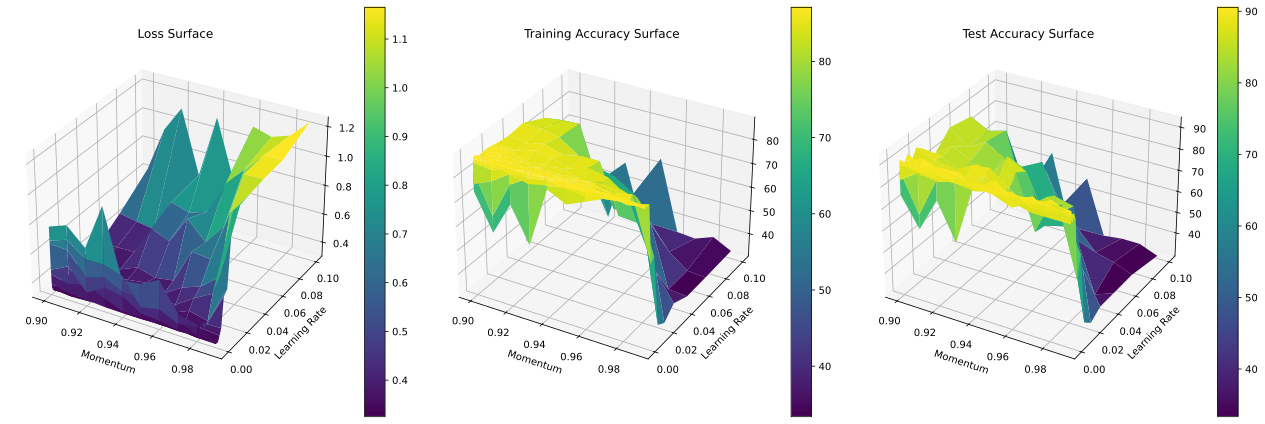

In [172]:
# Test different momentum values during training

momenta = np.linspace(0.9, 0.99, 10)
learning_rates = np.logspace(np.log10(.0001), np.log10(.1), 20)

# Initialize a results matrix to store training results.
results = np.zeros((numepochs, len(momenta), len(learning_rates), 3))

# Explanation:
# The `results` matrix is a multidimensional array with dimensions (numepochs, len(momenta), 3). It will be used to store training results, including losses, training accuracy, and test accuracy. Each dimension of the matrix corresponds to different aspects of the results.
# Create a dictionary to store the best models and their parameters
best_models = {
    'loss': {'value': float('inf'), 'params': None, 'model': None},
    'train_acc': {'value': -float('inf'), 'params': None, 'model': None},
    'test_acc': {'value': -float('inf'), 'params': None, 'model': None}
}

# Nested loops to test all combinations
for mom_idx, mom in enumerate(momenta):
    for lr_idx, lr in enumerate(learning_rates):
        print(f"Training with momentum={mom:.3f}, learning_rate={lr:.6f}")
        
        # Train the model with current parameter combination
        trainAcc, testAcc, losses, net = function2trainTheModel(mom, lr)
        
        # Store results
        results[:, mom_idx, lr_idx, 0] = losses      # Column 0 stores losses
        results[:, mom_idx, lr_idx, 1] = trainAcc    # Column 1 stores training accuracy
        results[:, mom_idx, lr_idx, 2] = testAcc     # Column 2 stores test accuracy
        
        # Update best models based on final epoch metrics
        final_loss = losses[-1]
        final_train_acc = trainAcc[-1]
        final_test_acc = testAcc[-1]
        
        # Check and update best loss
        if final_loss < best_models['loss']['value']:
            best_models['loss'] = {
                'value': final_loss,
                'params': {'momentum': mom, 'learning_rate': lr},
                'model': net
            }
        
        # Check and update best training accuracy
        if final_train_acc > best_models['train_acc']['value']:
            best_models['train_acc'] = {
                'value': final_train_acc,
                'params': {'momentum': mom, 'learning_rate': lr},
                'model': net
            }
        
        # Check and update best test accuracy
        if final_test_acc > best_models['test_acc']['value']:
            best_models['test_acc'] = {
                'value': final_test_acc,
                'params': {'momentum': mom, 'learning_rate': lr},
                'model': net
            }
            


In [189]:
best_models

{'loss': {'value': tensor(0.3200),
  'params': {'momentum': 0.97, 'learning_rate': 0.0026366508987303583},
  'model': qwertyNet(
    (input): Linear(in_features=2, out_features=8, bias=True)
    (fc1): Linear(in_features=8, out_features=8, bias=True)
    (output): Linear(in_features=8, out_features=3, bias=True)
  )},
 'train_acc': {'value': 88.0,
  'params': {'momentum': 0.95, 'learning_rate': 0.00042813323987193956},
  'model': qwertyNet(
    (input): Linear(in_features=2, out_features=8, bias=True)
    (fc1): Linear(in_features=8, out_features=8, bias=True)
    (output): Linear(in_features=8, out_features=3, bias=True)
  )},
 'test_acc': {'value': tensor(93.3333),
  'params': {'momentum': 0.95, 'learning_rate': 0.0018329807108324356},
  'model': qwertyNet(
    (input): Linear(in_features=2, out_features=8, bias=True)
    (fc1): Linear(in_features=8, out_features=8, bias=True)
    (output): Linear(in_features=8, out_features=3, bias=True)
  )}}

In [198]:
# First, run this magic command in a cell before creating the plot
%matplotlib notebook

In [199]:
# Function to analyze and visualize results
def analyze_results(results, momenta, learning_rates):
    # Get final epoch metrics for each parameter combination
    final_losses = results[-1, :, :, 0]
    final_train_acc = results[-1, :, :, 1]
    final_test_acc = results[-1, :, :, 2]
    
    # Create meshgrid for surface plotting
    M, L = np.meshgrid(momenta, learning_rates)
    
    return {
        'loss_surface': (M, L, final_losses.T),
        'train_acc_surface': (M, L, final_train_acc.T),
        'test_acc_surface': (M, L, final_test_acc.T)
    }

# Function to plot the results
def plot_results(analysis_data):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    
    metrics = ['loss_surface', 'train_acc_surface', 'test_acc_surface']
    titles = ['Loss Surface', 'Training Accuracy Surface', 'Test Accuracy Surface']
    
    fig = plt.figure(figsize=(18, 6))
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        M, L, Z = analysis_data[metric]
        
        surface = ax.plot_surface(M, L, Z, cmap='viridis')
        ax.set_xlabel('Momentum')
        ax.set_ylabel('Learning Rate')
        ax.set_title(title)
        plt.colorbar(surface, ax=ax)
    
    plt.tight_layout()
    plt.show()

In [200]:
# Analyze and visualize results
analysis_data = analyze_results(results, momenta, learning_rates)
plot_results(analysis_data)

<IPython.core.display.Javascript object>

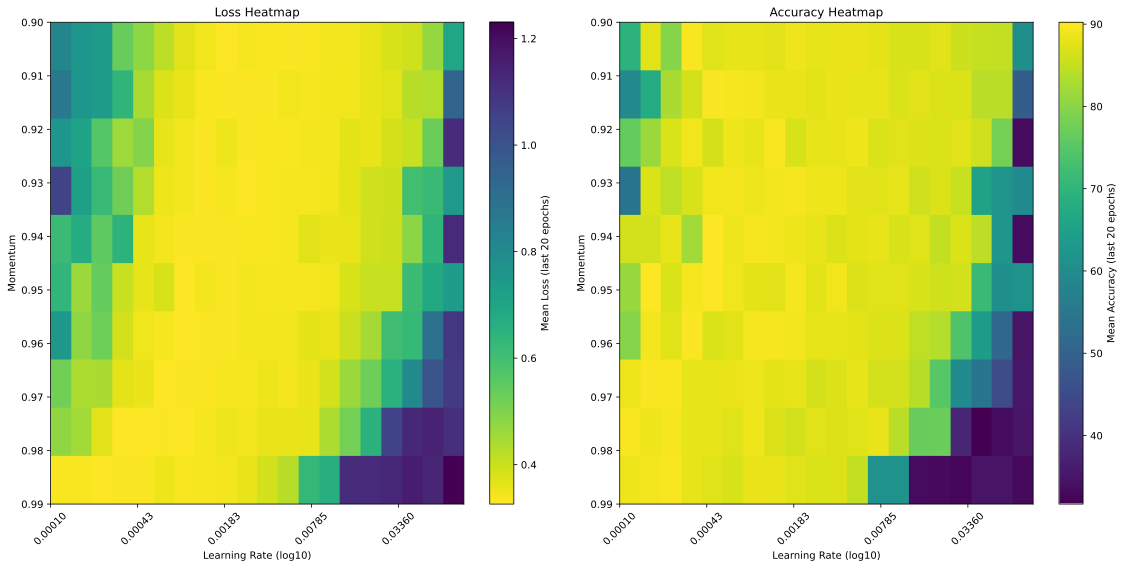

In [188]:
import seaborn as sns

# Initialize results matrices for final metrics
# We'll store only the mean of last 20 epochs for each parameter combination
final_losses = np.zeros((len(momenta), len(learning_rates)))
final_accuracies = np.zeros((len(momenta), len(learning_rates)))

# Test all combinations
for mom_idx, mom in enumerate(momenta):
    for lr_idx, lr in enumerate(learning_rates):        
        # Train the model with current parameter combination
        # trainAcc, testAcc, losses, net = function2trainTheModel(mom, lr)

        # Store results
        losses = results[:, mom_idx, lr_idx, 0]      # Column 0 stores losses
        trainAcc = results[:, mom_idx, lr_idx, 1]    # Column 1 stores training accuracy
        testAcc = results[:, mom_idx, lr_idx, 2]     # Column 2 stores test accuracy
        
        # Store mean of last 20 epochs
        final_losses[mom_idx, lr_idx] = np.mean(losses[-20:])
        final_accuracies[mom_idx, lr_idx] = np.mean(testAcc[-20:])

# Create figure with two subplots side by side
# plt.figure(figsize=(20, 8))

# # Plot loss heatmap
# plt.subplot(1, 2, 1)
# sns.heatmap(final_losses, 
#             xticklabels=[f'{lr:.5f}' for lr in learning_rates],
#             yticklabels=[f'{m:.3f}' for m in momenta],
#             cmap='viridis_r',  # Reversed viridis so darker = lower loss
#             annot=True,        # Show values in cells
#             fmt='.3f',         # Format for the annotations
#             cbar_kws={'label': 'Mean Loss (last 20 epochs)'})
# plt.xlabel('Learning Rate')
# plt.ylabel('Momentum')
# plt.title('Loss Heatmap')

# # Rotate x-axis labels for better readability
# plt.xticks(rotation=45)

# # Plot accuracy heatmap
# plt.subplot(1, 2, 2)
# sns.heatmap(final_accuracies,
#             xticklabels=[f'{lr:.5f}' for lr in learning_rates],
#             yticklabels=[f'{m:.3f}' for m in momenta],
#             cmap='viridis',    # Higher accuracy = darker color
#             annot=True,        # Show values in cells
#             fmt='.3f',         # Format for the annotations
#             cbar_kws={'label': 'Mean Accuracy (last 20 epochs)'})
# plt.xlabel('Learning Rate')
# plt.ylabel('Momentum')
# plt.title('Accuracy Heatmap')

# Create figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot loss heatmap
im1 = ax[0].imshow(final_losses, 
                   aspect='auto',
                   interpolation='nearest',
                   extent=[np.log10(learning_rates[0]), np.log10(learning_rates[-1]), 
                          momenta[-1], momenta[0]],
                   cmap='viridis_r')  # Reversed viridis so darker = lower loss

# Customize loss plot
ax[0].set_xlabel('Learning Rate (log10)')
ax[0].set_ylabel('Momentum')
ax[0].set_title('Loss Heatmap')
# ax[0].set_xscale('log')  # Set x-axis to log scale

# Add colorbar for loss
cbar1 = plt.colorbar(im1, ax=ax[0])
cbar1.set_label('Mean Loss (last 20 epochs)')

# Create custom x-ticks for learning rates (in log scale)
log_lr_ticks = np.log10(learning_rates[::4])  # Show every 4th value
ax[0].set_xticks(log_lr_ticks)
ax[0].set_xticklabels([f'{10**x:.5f}' for x in log_lr_ticks], rotation=45)

# Plot accuracy heatmap
im2 = ax[1].imshow(final_accuracies, 
                   aspect='auto',
                   interpolation='nearest',
                   extent=[np.log10(learning_rates[0]), np.log10(learning_rates[-1]), 
                          momenta[-1], momenta[0]],
                   cmap='viridis')  # Higher accuracy = darker color

# Customize accuracy plot
ax[1].set_xlabel('Learning Rate (log10)')
ax[1].set_ylabel('Momentum')
ax[1].set_title('Accuracy Heatmap')
# ax[1].set_xscale('log')  # Set x-axis to log scale

# Add colorbar for accuracy
cbar2 = plt.colorbar(im2, ax=ax[1])
cbar2.set_label('Mean Accuracy (last 20 epochs)')

# Create custom x-ticks for learning rates (in log scale)
ax[1].set_xticks(log_lr_ticks)
ax[1].set_xticklabels([f'{10**x:.5f}' for x in log_lr_ticks], rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Additional explorations

In [164]:
# 1) Now that you see the results across a broad range of beta (momentum) parameters, try re-running the experiment
#    using a narrower range. For example, you don't need to test b=0 or b=.999.
# 
# 2) The beta parameter multiplies the learning rate in the computation (see formula in slides). That means that these
#    results will interact with the learning rate. Repeat the experiment using a different learning rate.
# 
# 3) If you wanted to test the relationship between momentum and learning rate in a full parametric experiment, how would
#    you set it up? Would you store the loss/accuracy over all epochs? 
# 